# SAGE-Spec cubes and PAHFIT

In [7]:
from astropy.io import fits
from astropy.table import Table
from matplotlib import pyplot as plt
import numpy as np

In [8]:
from astropy.wcs import WCS

def wavs_cube_wcs2d(fn):
    cube = fits.open(fn)[0]
    wavs = Table.read(fn)['WAVELENGTH'][0]
    wcs = WCS(fn, naxis=2)
    return dict(filename=fn, cube=cube, wavelength=wavs, wcs=wcs)

# load these cubes for testing
ll1 = wavs_cube_wcs2d("data/sage-spec_hii1_hii8_4dec08/hii1_hii8_ll_LL1_cube.fits")
ll2 = wavs_cube_wcs2d("data/sage-spec_hii1_hii8_4dec08/hii1_hii8_ll_LL2_cube.fits")
sl1 = wavs_cube_wcs2d("data/sage-spec_hii1_hii8_4dec08/hii1_hii8_sl_SL1_cube.fits")
sl2 = wavs_cube_wcs2d("data/sage-spec_hii1_hii8_4dec08/hii1_hii8_sl_SL2_cube.fits")

INFO: 
                Inconsistent SIP distortion information is present in the FITS header and the WCS object:
                SIP coefficients were detected, but CTYPE is missing a "-SIP" suffix.
                astropy.wcs is using the SIP distortion coefficients,
                therefore the coordinates calculated here might be incorrect.

                If you do not want to apply the SIP distortion coefficients,
                please remove the SIP coefficients from the FITS header or the
                WCS object.  As an example, if the image is already distortion-corrected
                (e.g., drizzled) then distortion components should not apply and the SIP
                coefficients should be removed.

                While the SIP distortion coefficients are being applied here, if that was indeed the intent,
                for consistency please append "-SIP" to the CTYPE in the FITS header or the WCS object.

                 [astropy.wcs.wcs]
INFO: 
             

## Inspect some data

In [9]:
fn = "data/sage-spec_hii1_hii8_4dec08/hii1_hii8_ll_LL1_cube.fits"
fits.info(fn)

Filename: data/sage-spec_hii1_hii8_4dec08/hii1_hii8_ll_LL1_cube.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU     227   (88, 14, 99)   float32   
  1  WCS-TAB       1 BinTableHDU     13   1R x 1C   [99E]   


In [10]:
wavtable = Table.read(fn)
wavtable

"WAVELENGTH [99,1]"
um
float32
20.52005 .. 38.333282


## Plotting the orders

In [11]:
def plot_total(fn):
    wavs = Table.read(fn)['WAVELENGTH'][0]
    cube = fits.open(fn)[0]
    plt.plot(wavs, np.nansum(cube.data, axis=(1,2)))

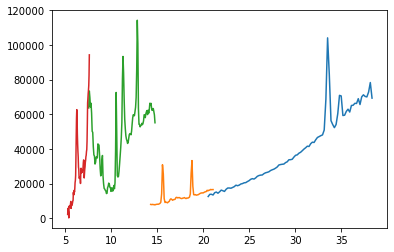

In [12]:
plot_total("data/sage-spec_hii1_hii8_4dec08/hii1_hii8_ll_LL1_cube.fits")
plot_total("data/sage-spec_hii1_hii8_4dec08/hii1_hii8_ll_LL2_cube.fits")
plot_total("data/sage-spec_hii1_hii8_4dec08/hii1_hii8_sl_SL1_cube.fits")
plot_total("data/sage-spec_hii1_hii8_4dec08/hii1_hii8_sl_SL2_cube.fits")

## Setting up WCS

In [13]:
print(ll1['wcs'], ll2['wcs'])

WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---TAN'  'DEC--TAN'  
CRVAL : 73.02776135  -66.9502936972  
CRPIX : 44.5  7.5  
PC1_1 PC1_2  : -0.00194042951454  -0.999998117365  
PC2_1 PC2_2  : 0.999998117365  -0.00194042951454  
CDELT : -0.00141111109406  0.00141111109406  
NAXIS : 88  14  99 WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---TAN'  'DEC--TAN'  
CRVAL : 73.0281179792  -66.897078608  
CRPIX : 44.5  7.5  
PC1_1 PC1_2  : -0.00194042951454  -0.999998117365  
PC2_1 PC2_2  : 0.999998117365  -0.00194042951454  
CDELT : -0.00141111109406  0.00141111109406  
NAXIS : 88  14  75


## Extracting spectrum within aperture
Here I wil try to load in all the cubes for one observation, and extract an merge the spectra within a certain aperture. I can probably use astropy or photutils for this. 

I think the plan for later would then be, to generate a grid of apertures, which will determine a set of spectra to be fit by PAHFIT. Once the fit results have been gathered for each aperture on this grid, the results could be compiled into a map for each feature, where the resolution depends on the original definition of the grid.

First let's try with two apertures

In [16]:
import photutils
from astropy.coordinates import SkyCoord
from astropy import units as u

def show_slice(cube_dict, slice_index):
    plt.subplot(projection=cube_dict['wcs'])
    plt.imshow(cube_dict['cube'].data[-1])
    plt.grid()
    circle.to_pixel(cube_dict['wcs']).plot(color='r')

In [17]:
positions = SkyCoord(ra=['4h52m8s','4h52m6s'], dec=['-66d55m15s','-66d55m15s'],
                     frame='icrs')
circle = photutils.aperture.SkyCircularAperture(positions, r=1.5*u.arcsec)
circle

<SkyCircularAperture(<SkyCoord (ICRS): (ra, dec) in deg
    [(73.03333333, -66.92083333), (73.025     , -66.92083333)]>, r=1.5 arcsec)>

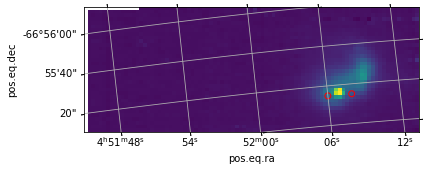

In [19]:
show_slice(sl1, -1)

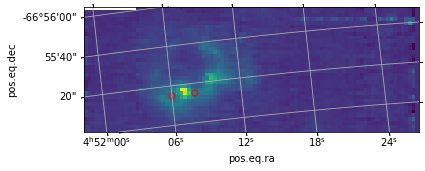

In [20]:
show_slice(sl2, -1)

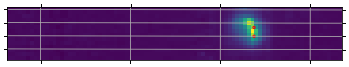

In [21]:
show_slice(ll1, -1)

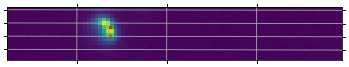

In [22]:
show_slice(ll2, -1)

In [23]:
def extract_spectrum(cube_dicts, sky_aperture):
    wavtables = [d['wavelength'] for d in cube_dicts]
    cubes = [d['cube'] for d in cube_dicts]
    wcses = [d['wcs'] for d in cube_dicts]
    
    # prepare output table
    total_wavs = sum((len(w) for w in wavtables))
    
    # output will be table with wavelength in first column, and the flux for each aperture in the following columns (only 1 for now)
    output = np.zeros((total_wavs, 2))
    
    # perform aperture photometry on every slice of every cube
    row_counter = 0
    for i in range(len(cubes)):        
        for w in range(len(wavtables[i])):
            output[row_counter, 0] = wavtables[i][w]
            image = cubes[i].data[w]
            photometry_result = photutils.aperture.aperture_photometry(image, sky_aperture, wcs=wcses[i])
            output[row_counter, 1] = photometry_result[0]['aperture_sum']
            row_counter += 1
                       
    return output

In [24]:
results = extract_spectrum([sl1, sl2, ll1, ll2], circle[0])

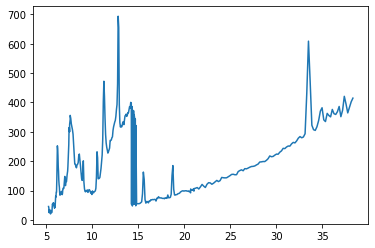

In [25]:
sorted_results = results[np.argsort(results[:,0])]
plt.plot(sorted_results[:, 0], sorted_results[:,1])

The jump still exists...

## Grid of apertures


In [ ]:
#def ra_dec_grid_for_cubes()

# try to come up with a suitable RA-DEC grid to use for the apertures, given the four cubes

# best solution might be manual (look at image, and specify limits indicating area of interest)
def manual_aperture_grid(ra_min, ra_max, dec_min, dec_max, size):
    
    centers = SkyCoord(ra=ras, dec=decs, frame='icrs')
    apertures = photutils.aperture.SkyRectangularAperture(centers, size, size)
    return apertures


In [34]:
import itertools as it
from photutils.aperture import SkyRectangularAperture

# the wcs we want our final map to have
def make_ra_dec_wcs(center_ra, center_dec, pix_angle_delta, npix_ra, npix_dec):
    """
    Make simple WCS where X and Y are aligned with RA and DEC, respectively.
    
    center_ra, center_dec: determines crval
    
    pix_angle_delta: physical distance between pixels, in decimal degrees
    
    npix_ra, npix_dec: number of pixels along each axis. Is needed to make sure that (center_ra, center_dec) corresponds to the middle of the image. 
    The physical image size will be pix_angle_delta * npix.
    """
    w = WCS(naxis=2)
    # center of each pixel = 1, 2, 3, ...
    # 3 pixels --> center is 2
    # 4 pixels --> center is 2.5 (border between 2 and 3)
    center_x = center_ra / 2 + .5
    center_y = center_dec / 2 + .5
    w.wcs.crpix = [center_x, center_y]
    w.wcs.crval = [center_ra, center_dec]
    w.wcs.cdelt = [pix_angle_delta, pix_angle_delta]
    w.wcs.ctype = ["RA---TAN", "DEC--TAN"]
    return w
    
def make_square_aperture_grid(center_ra, center_dec, pix_angle_delta, npix_ra, npix_dec):
    """
    Use the above wcs create a set of sky apertures representing the pixels in our map.
    
    Use sky apertures immediately (instead of starting with pixel apertures and then converting),
    to make picking the right size easier.
    """
    # all xy pairs
    X, Y = np.mgrid[:npix_ra, :npix_dec]
    x = X.flatten()
    y = Y.flatten()
    
    w = make_ra_dec_wcs(center_ra, center_dec, pix_angle_delta, npix_ra, npix_dec)
    positions = w.pixel_to_world(x, y)
    size = pix_angle_delta * u.degree
    return photutils.aperture.SkyRectangularAperture(positions, size, size)
